# MIE451/1513 Decision Support System -- Data Science Solution

In [1]:
# check the current python version
import sys
print(sys.version)

3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [2]:
# installing useful libraries
!pip install folium
!pip install tqdm
!pip install numpy
!pip install pandas
!pip install nltk
!pip install scikit-learn
!pip install scipy
!pip install geopy
!pip install tabulate
!pip install textblob
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 84.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# importing useful libraries

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

#Data Packages
import math
import pandas as pd
import numpy as np

#Progress bar
from tqdm import tqdm

#Counter
from collections import Counter

#Operation
import operator

#Natural Language Processing Packages
import re
import nltk

## Download Resources
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tag import PerceptronTagger
from nltk.data import find

## Machine Learning
import sklearn
import sklearn.metrics as metrics

## Data Visualization
import folium
from tabulate import tabulate
from scipy.stats.kde import gaussian_kde

## Geolocation
import geopy
from geopy.geocoders import Photon
from geopy.extra.rate_limiter import RateLimiter

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-3-1b867c54f60b>:48: DeprecationWarning: Please import `gaussian_kde` from the `scipy.stats` namespace; the `scipy.stats.kde` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.kde import gaussian_kde


In [4]:
# setting pandas' display
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 500)

In [175]:
#Read in from pandas
columnNames = ['filePath','hotelName','reviewColumn','ratingScore','groundTruth',
               'date_stamp','streetAddress', 'City',
               'Province','postalCode']

hotelDf = pd.read_csv('https://raw.github.com/MIE451-2024/course-datasets/main/blue-mountain-sample.csv',
                          header=None,
                          names=columnNames)

In [176]:
hotelDf.head()

,filePath,hotelName,reviewColumn,ratingScore,groundTruth,date_stamp,streetAddress,City,Province,postalCode
0,data\ca\1022639\13963231\637633732.html,The Retreat House,"""What more can I say about The Retreat House. The B&B is located 7kms up Bleu Mountain. We drove in and the trees and homes where layered in snow.\nIf you want to relaxed and get away from things this is the perfect place. Jen and Deb are amazing hosts. Deb made us two amazing breakfasts and gave us recommendations on things to do and see. We will definitely be back.",5,positive,"December 5, 2018",120 Tyrol Ave,NaN,Ontario,N0H 2E0
1,data\ca\1022639\13963231\641552435.html,The Retreat House,"""This place was wonderfull! We stayed 2 nights and visited Blue Mountain for ski\u2019ing. \nThe room was great - very comfortable and cosy. There is a communial kitchen and lounge for relaxing- and that too is very comfortable and cosy. \nEverything you need is provided and the hosts goes out of their way to make your stay comfortable and memorable. \nBreakfasts was lovely- prepared fresh and homemade by the hosts. \n\nIt is situated at the top of the mountain and you need a car or a taxi t...",5,positive,"December 26, 2018",120 Tyrol Ave,NaN,Ontario,N0H 2E0
2,data\ca\1022639\13963231\650610730.html,The Retreat House,"""My husband and I went for our anniversary, and we were definitely in for a treat!\n\nThis place is out of the hustle and bustle!\n\nBeautiful setting, with wonderful \u201Cstaff\u201D that made us feel like old-time friends.\n\nWe stayed in the house separate from the main house.\nSelf catering facility, but we went to the main \u2018house\u2019 because boy oh boy do they know how to cook.\n\nEach morning we were welcomed with beautiful Christmas music, a warm coffee\u002F tea\u002F hot cho...",5,positive,"February 6, 2019",120 Tyrol Ave,NaN,Ontario,N0H 2E0
3,data\ca\1022639\13963231\672145484.html,The Retreat House,"""I came for a yoga retreat with some friends. We stayed in the 2 storey house that did NOT have the kitchen...on the upper level in the open area with several beds. We had booked late and this was all that was available. It was fine but I would have rather had my own room. The upper level did have a separate room for one guest and we all shared the one washroom on the main floor but had to shower in the main house. The main floor was an open space used for yoga and the place was heated ...",4,positive,"May 7, 2019",120 Tyrol Ave,NaN,Ontario,N0H 2E0
4,data\ca\1022639\13963231\713132164.html,The Retreat House,"""Well, I had a very late arrival. As I walked towards the warm glow of candle light and happy chatter, I walk through the back to see a beautiful rustic dream. The ladies were hosting a group of ladies on a yoga retreat, with wine in their glasses, empty plates and smiles on their faces. The rooms scent was filled with a Apple cinnamon, which was a homemade dessert, alongside vegan ice cream!!! \nThe ladies were super sweet and very and wonderful hosts and great to chat with in the morning ...",5,positive,"September 26, 2019",120 Tyrol Ave,NaN,Ontario,N0H 2E0


In [177]:
def evalSentences(sentences, to_df=False, columns=[]):
    #Instantiate an instance to access SentimentIntensityAnalyzer class
    sid = SentimentIntensityAnalyzer()
    pdlist = []
    if to_df:
        for sentence in tqdm(sentences):
            ss = sid.polarity_scores(sentence)
            pdlist.append([sentence]+[ss['compound']])
        reviewDf = pd.DataFrame(pdlist)
        reviewDf.columns = columns
        return reviewDf

    else:
        for sentence in tqdm(sentences):
            print(sentence)
            ss = sid.polarity_scores(sentence)
            for k in sorted(ss):
                print('{0}: {1}, '.format(k, ss[k]), end='')
            print()

# Q1

####(a) Compute average Vader sentiment and average ground truth rating per hotel.

In [178]:
reviews = hotelDf['reviewColumn'].values

In [179]:
reviewDF = evalSentences(reviews, to_df=True, columns=['reviewCol','vader'])

100%|██████████| 1971/1971 [00:03<00:00, 629.13it/s]


In [180]:
reviewDF.head()

,reviewCol,vader
0,"""What more can I say about The Retreat House. The B&B is located 7kms up Bleu Mountain. We drove in and the trees and homes where layered in snow.\nIf you want to relaxed and get away from things this is the perfect place. Jen and Deb are amazing hosts. Deb made us two amazing breakfasts and gave us recommendations on things to do and see. We will definitely be back.",0.9601
1,"""This place was wonderfull! We stayed 2 nights and visited Blue Mountain for ski\u2019ing. \nThe room was great - very comfortable and cosy. There is a communial kitchen and lounge for relaxing- and that too is very comfortable and cosy. \nEverything you need is provided and the hosts goes out of their way to make your stay comfortable and memorable. \nBreakfasts was lovely- prepared fresh and homemade by the hosts. \n\nIt is situated at the top of the mountain and you need a car or a taxi t...",0.9887
2,"""My husband and I went for our anniversary, and we were definitely in for a treat!\n\nThis place is out of the hustle and bustle!\n\nBeautiful setting, with wonderful \u201Cstaff\u201D that made us feel like old-time friends.\n\nWe stayed in the house separate from the main house.\nSelf catering facility, but we went to the main \u2018house\u2019 because boy oh boy do they know how to cook.\n\nEach morning we were welcomed with beautiful Christmas music, a warm coffee\u002F tea\u002F hot cho...",0.9666
3,"""I came for a yoga retreat with some friends. We stayed in the 2 storey house that did NOT have the kitchen...on the upper level in the open area with several beds. We had booked late and this was all that was available. It was fine but I would have rather had my own room. The upper level did have a separate room for one guest and we all shared the one washroom on the main floor but had to shower in the main house. The main floor was an open space used for yoga and the place was heated ...",0.9754
4,"""Well, I had a very late arrival. As I walked towards the warm glow of candle light and happy chatter, I walk through the back to see a beautiful rustic dream. The ladies were hosting a group of ladies on a yoga retreat, with wine in their glasses, empty plates and smiles on their faces. The rooms scent was filled with a Apple cinnamon, which was a homemade dessert, alongside vegan ice cream!!! \nThe ladies were super sweet and very and wonderful hosts and great to chat with in the morning ...",0.9929


In [181]:
finalreviewDf = hotelDf[['hotelName','groundTruth']].join(reviewDF)

def avg_rating_per_hotel(df):
  # map 'positive', 'negative', 'neutral' to numeric values
  sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
  df['groundTruthScore'] = df['groundTruth'].map(sentiment_mapping)

  # average the scores over all hotels, you may need to provide additional filtering
  tempDf = df[['hotelName','vader','groundTruthScore','reviewCol']]
  tempDf.columns = ['hotelName','AverageVader', 'AverageGroundTruth','n_reviews']
  tempDf = tempDf.groupby('hotelName').agg({'AverageVader':'mean', 'AverageGroundTruth':'mean','n_reviews':'count'})

  # map numeric ground truth values back to 'positive', 'negative', 'neutral'
  tempDf['AverageGroundTruth'] = tempDf['AverageGroundTruth'].apply(lambda x: 'positive' if x > 0 else 'neutral' if x == 0 else 'negative') #gpt
  return tempDf

avg_rating_per_hotel(finalreviewDf)

,AverageVader,AverageGroundTruth,n_reviews
hotelName,,,
Beacon Shore Bed &amp; Breakfast,0.976018,positive,100
Best Western Plus Walkerton Hotel &amp; Conference Centre,0.890364,positive,100
Blue Mountain Inn,-0.273400,negative,4
Blue Mountain Inn by Blue Mountain Resort,0.553337,positive,100
Blue Mountain Resort,0.945000,positive,1
Blue View Chalets,0.838780,positive,15
Bluebird Meadows Bed &amp; Breakfast,0.960638,positive,80
Bowering Guest House,0.768640,positive,10
Clearview Station Bed and Breakfast,0.947061,positive,85


####(b) Rank hotels by
1.   Average Ground Truth Sentiment
2.   Average Vader Compound Sentiment Score
3.   Median Vader Compound Sentiment Score


In [182]:
def rank_rating_per_hotel(df):
  # map 'positive', 'negative', 'neutral' to numeric values
  sentiment_mapping = {'positive': 1, 'negative': -1, 'neutral': 0}
  df['groundTruthScore'] = df['groundTruth'].map(sentiment_mapping)

  tempDf = df[['hotelName','vader','groundTruthScore','reviewCol']]
  tempDf.columns = ['hotelName','vader', 'groundTruthScore','n_reviews']
  tempDf = tempDf.groupby('hotelName').agg({'vader':['mean', 'median'], 'groundTruthScore':'mean','n_reviews':'count'}).reset_index()
  tempDf.columns = ['hotelName', 'AverageVader', 'MedianVader', 'AverageGroundTruth', 'ReviewCount']

  # rank
  tempDf['Rank_AverageGroundTruth'] = tempDf['AverageGroundTruth'].rank(ascending=False)
  tempDf['Rank_AverageVader'] = tempDf['AverageVader'].rank(ascending=False)
  tempDf['Rank_MedianVader'] = tempDf['MedianVader'].rank(ascending=False)

  # tempDf['AverageGroundTruth'] = tempDf['AverageGroundTruth'].apply(lambda x: 'positive' if x > 0 else 'neutral' if x == 0 else 'negative')

  return tempDf

result = rank_rating_per_hotel(finalreviewDf)

print("top-5 Average Ground Truth Sentiment")
print(result.nlargest(5, 'AverageGroundTruth'))

print("\ntop-5 Average Vader Compound Sentiment Score")
print(result.nlargest(5, 'AverageVader'))

print("\ntop-5 Median Vader Compound Sentiment Score")
print(result.nlargest(5, 'MedianVader'))

print("\nbottom-5 Average Ground Truth Sentiment")
print(result.nsmallest(5, 'AverageGroundTruth'))

print("\nbottom-5 Average Vader Compound Sentiment Score")
print(result.nsmallest(5, 'AverageVader'))

print("\nbottom-5 Median Vader Compound Sentiment Score")
print(result.nsmallest(5, 'MedianVader'))

top-5 Average Ground Truth Sentiment
                                hotelName  AverageVader  MedianVader  AverageGroundTruth  ReviewCount  Rank_AverageGroundTruth  Rank_AverageVader  Rank_MedianVader
0        Beacon Shore Bed &amp; Breakfast      0.976018      0.98355                 1.0          100                      5.0                3.0               3.0
4                    Blue Mountain Resort      0.945000      0.94500                 1.0            1                      5.0               11.0              19.0
6    Bluebird Meadows Bed &amp; Breakfast      0.960638      0.97725                 1.0           80                      5.0                7.0               8.0
13  Escarpment Escape Bed &amp; Breakfast      0.982940      0.98740                 1.0            5                      5.0                1.0               1.0
15      Heathcote Haven Bed and Breakfast      0.975562      0.98150                 1.0           40                      5.0                4

The results are very similar for both top-5 and bottom-5

# Q2

####(a) Use term frequency to rank the top-50 most frequent non-stop words in both ground truth (i) positive reviews and (ii) negative reviews. Show the word cloud for each category.

In [194]:
def get_stop_words():
    stop = set(stopwords.words('english'))
    #Add possible Stop Words for Hotel Reviews
    stop.add('hotel')
    stop.add('room')
    stop.add('rooms')
    stop.add('stay')
    stop.add('staff')
    return stop

def getTopKWords(df, kwords, polarity):

    stop = get_stop_words()
    counter = Counter()

    reviews = df.loc[operator.eq(df['groundTruth'], polarity)]['reviewColumn']

    for review in reviews:
            counter.update([word.lower()
                            for word
                            in re.findall(r'\w+', review)
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

# Note: You may want to use an NLTK tokenizer instead of a regular expression in the following
def dataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values

    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter([word.lower() for word in re.findall(r'\w+',reviews[i])])
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)


    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [195]:
top50_pos = getTopKWords(hotelDf, 50, 'positive')
top50_neg = getTopKWords(hotelDf, 50, 'negative')

print("Top 50 Ground Truth Positive Reviews")
print(top50_pos)
print("\nTop 50 Ground Truth Negative Reviews")
print(top50_neg)

Top 50 Ground Truth Positive Reviews
[('great', 941), ('breakfast', 722), ('clean', 693), ('stayed', 566), ('would', 527), ('nice', 496), ('time', 493), ('area', 493), ('well', 493), ('place', 478), ('village', 478), ('comfortable', 457), ('one', 447), ('blue', 432), ('mountain', 407), ('back', 403), ('good', 386), ('friendly', 371), ('hot', 362), ('beautiful', 354), ('hosts', 349), ('pool', 337), ('night', 332), ('also', 325), ('everything', 323), ('home', 322), ('recommend', 308), ('location', 303), ('bed', 302), ('really', 301), ('nthe', 291), ('made', 290), ('weekend', 289), ('like', 285), ('wonderful', 283), ('tub', 269), ('day', 268), ('definitely', 263), ('perfect', 259), ('two', 258), ('enjoyed', 252), ('amazing', 246), ('could', 243), ('family', 241), ('view', 230), ('get', 227), ('excellent', 226), ('experience', 223), ('helpful', 221), ('lovely', 219)]

Top 50 Ground Truth Negative Reviews
[('would', 261), ('one', 224), ('place', 169), ('night', 167), ('nice', 153), ('villag

"would", "one", "place", "night", "nice", "village", "get", "bed", "could", "time", "mountain", "good", "stayed", "like", "desk", "day", "pool", "nthe", "resort", "clean", "blue", "back", "well", "great", "two", "area", "also", "hot", "tub", "breakfast" are words that appear in both positive and negative reviews.(asked gpt)

Ones that surprise me are "nice", "good", "well", and "great" which seem to have very positive meanings.

####(b) Repeat the analysis in Q2(a) for the top-50 noun phrases (using the provided grammar pattern below).

In [122]:
tagger = PerceptronTagger()
pos_tag = tagger.tag

In [123]:
grammar = r"""
  NBAR:
    {<NN.*|JJ>*<NN.*>} # Nouns and Adjectives, terminated with Nouns
  NP:
    {<NBAR><IN><NBAR>}
    {<NBAR>} # Above, connected with in/of/etc...
"""

In [124]:
# Create phrase tree
chunker = nltk.RegexpParser(grammar)

In [125]:
# to make the results more useable, we clean up the tree results shown above.
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

# generator, create item one a time
def get_terms(tree, remove_stopwords=True):
    for leaf in leaves(tree):

        term = []

        for w, t in leaf:
            if remove_stopwords:
                if acceptable_word(w):
                    term.append(normalise(w))

            else:
                term.append(normalise(w))

        # Phrase only
        if len(term) > 1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds NP (nounphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' or t.label()=='JJ' or t.label()=='RB'):
        yield subtree.leaves()

# stemming, lematizing, lower case...
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        if len(token) > 0: # don't return empty tokens
            finalList.append(token.rstrip())
    return finalList

In [136]:
# getting top noun phrases
def getTopKNP(df, kNPs, polarity):

    counter = Counter()
    reviews = df.loc[operator.eq(df['groundTruth'], polarity)]['reviewColumn']

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))
                            ]))
    topk = counter.most_common(kNPs)
    return topk


def NPdataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewCol'].values

    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word
                                       for word
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)


    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [74]:
print("Top 50 Ground Truth Positive NPs")
top50_pos_phrase = getTopKNP(hotelDf, 50, 'positive')
print(top50_pos_phrase)
print("\nTop 50 Ground Truth Negative NPs")
top50_neg_phrase = getTopKNP(hotelDf, 50, 'negative')
print(top50_neg_phrase)

Top 50 Ground Truth Positive NPs
[('hot tub', 131), ('blue mountain', 108), ('front desk', 66), ('highland manor', 57), ('georgian bay', 40), ('great place', 39), ('minut walk', 37), ('beacon shore', 37), ('first time', 36), ('owen sound', 34), ('great time', 33), ('bedroom suit', 28), ('great locat', 27), ('minut drive', 27), ('blue mountain villag', 26), ('bluebird meadow', 24), ('bruce trail', 22), ('great experi', 21), ('comfort bed', 21), ('delici breakfast', 20), ('short drive', 19), ('wonder host', 18), ('outdoor hot tub', 18), ('outdoor pool', 18), ('great host', 18), ('full kitchen', 18), ('bedroom unit', 18), ('first experi', 18), ('island view', 18), ('blue mountain inn', 17), ('short walk', 17), ('great view', 16), ('tyrolean villag', 16), ('next time', 15), ('next year', 15), ('wonder experi', 15), ('live area', 15), ('queen bed', 15), ('main floor', 14), ('second floor', 14), ('perfect spot', 14), ('muskoka chair', 14), ('grand georgian', 14), ('excel host', 14), ('tuck i

"hot tub", "blue mountain", "front desk", "first time", "great time", "bedroom suit", "great locat", "minut walk", "blue mountain villag", "blue mountain inn", "next time", "next morn", "main floor", "second floor", "grand georgian", "outdoor pool", "queen bed", "bedroom unit", "long time" are noun phrases that appear in both positive and negative reviews. (asked gpt)

An unexpected noun phrase in positive reviews is "great time" as this phrase is very positive. It may appear in a negative review if, for example, a guest mentions that they did "not" have a "great time"

####(c) Define a grammar for a phrase pattern (different from the one already provided) that you think would be helpful for review analysis – you may refer to the Chapter 7 of the NLTK book1 for more information about various possible phrase patterns. Repeat the analysis in Q2(a) with this phrase pattern.

In [151]:
# verb phrases
grammar_VP = r"""
  VP:
    {<VB.*><RB>?<JJ>*<NN.*>+}       # Verb + optional adverb + optional adjectives + one or more nouns
    {<VB.*><DT>?<NN.*>+<IN><NN.*>+}  # Verb + optional determiner + noun(s) + preposition + noun(s)
"""

In [152]:
# Create phrase tree
chunker = nltk.RegexpParser(grammar_VP)

In [153]:
# to make the results more useable, we clean up the tree results shown above.
lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.stem.porter.PorterStemmer()
stopword_list = get_stop_words()

# generator, create item one a time
def get_terms(tree, remove_stopwords=True):
    for leaf in leaves(tree):

        term = []

        for w, t in leaf:
            if remove_stopwords:
                if acceptable_word(w):
                    term.append(normalise(w))

            else:
                term.append(normalise(w))

        # Phrase only
        if len(term) > 1:
            yield term

# generator, generate leaves one by one
def leaves(tree):
    """Finds VP (verbphrase) leaf nodes of a chunk tree."""
    for subtree in tree.subtrees(filter = lambda t: t.label()=='VP'):
        yield subtree.leaves()

# stemming, lematizing, lower case...
def normalise(word,lemmatizer=lemmatizer, stemmer=stemmer):
    """Normalises words to lowercase and stems and lemmatizes it."""
    word = word.lower()
    word = stemmer.stem(word)
    word = lemmatizer.lemmatize(word)
    return word

# stop-words and length control
def acceptable_word(word, stopword_list=stopword_list):
    """Checks conditions for acceptable word: length, stopword."""
    accepted = bool(2 <= len(word) <= 40
        and word.lower() not in stopword_list)
    return accepted

# Flatten phrase lists to get tokens for analysis
def flatten_phrase_lists(npTokenList):
    finalList =[]
    for phrase in npTokenList:
        token = ''
        for word in phrase:
            token += word + ' '
        if len(token) > 0: # don't return empty tokens
            finalList.append(token.rstrip())
    return finalList

# getting top verb phrases
def getTopKVP(df, kVPs, polarity):

    counter = Counter()
    reviews = df.loc[operator.eq(df['groundTruth'], polarity)]['reviewColumn']

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))
                            ]))
    topk = counter.most_common(kVPs)
    return topk


def VPdataFrameTransformation(hotelDf, reviewDF, topk):
    reviews = reviewDF['reviewColumn'].values

    #Find out if a particular review has the word from topk list
    freqReview = []
    for i in range(len(reviews)):
        tempCounter = Counter(flatten_phrase_lists([word
                                       for word
                                       in get_terms(chunker.parse(pos_tag(re.findall(r'\w+',reviews[i]))))]))
        topkinReview = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
        freqReview.append(topkinReview)


    #Prepare freqReviewDf
    freqReviewDf = pd.DataFrame(freqReview)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    freqReviewDf.columns = dfName
    finalreviewDf = reviewDF.join(freqReviewDf)
    finaldf = hotelDf[['hotelName','ratingScore','groundTruth']].join(finalreviewDf)
    return finaldf

In [82]:
print("Top 50 Ground Truth Positive VPs")
top50_pos_verb_phrase = getTopKVP(hotelDf, 50, 'positive')
print(top50_pos_verb_phrase)
print("\nTop 50 Ground Truth Negative VPs")
top50_neg_verb_phrase = getTopKVP(hotelDf, 50, 'negative')
print(top50_pos_verb_phrase)

Top 50 Ground Truth Positive VPs
[('walk distanc', 66), ('surround area', 15), ('blue mountain', 13), ('sit area', 13), ('swim pool', 12), ('taken care', 12), ('wonder host', 12), ('great host', 12), ('dine area', 10), ('took advantag', 10), ('top notch', 10), ('take advantag', 10), ('excel host', 10), ('took care', 7), ('heat pool', 7), ('need anyth', 7), ('take care', 7), ('overlook georgian bay', 7), ('dine tabl', 6), ('super comfi', 6), ('visit blue mountain', 5), ('seat area', 5), ('work order', 5), ('made reserv', 5), ('spend time', 5), ('front desk', 5), ('u2019t wait', 5), ('walk trail', 5), ('graciou host', 5), ('welcom host', 5), ('first class', 5), ('back thank', 4), ('nthe home', 4), ('live area', 4), ('watch tv', 4), ('love everyth', 4), ('go ski', 4), ('park lot', 4), ('king size', 4), ('hear peopl', 4), ('hike trail', 4), ('mani restaur', 4), ('went way', 4), ('clean bed', 4), ('perfect host', 4), ('tuck inn', 4), ('cook breakfast', 4), ('equip kitchen', 3), ('good nthe'

In [79]:
# setting default parameters of WordCloud object
wordcloud_args = dict(
    width = 800,
    height = 800,
    background_color ='white',
    min_font_size = 10
    )

# fucntion to plot word cloud
def plotWordCloud(dictionary, **kwargs):
    wordcloud = WordCloud(**kwargs)

    wordcloud.generate_from_frequencies(dict(dictionary))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

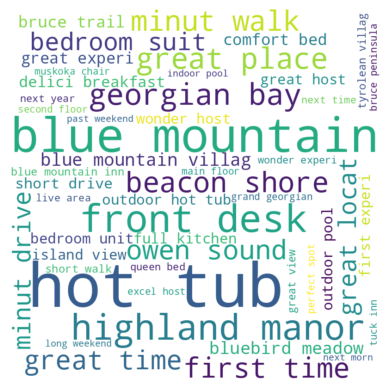

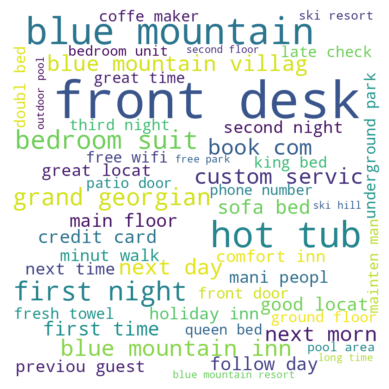

In [80]:
plotWordCloud(top50_pos_phrase, **wordcloud_args)
print("\n")
plotWordCloud(top50_neg_phrase, **wordcloud_args)

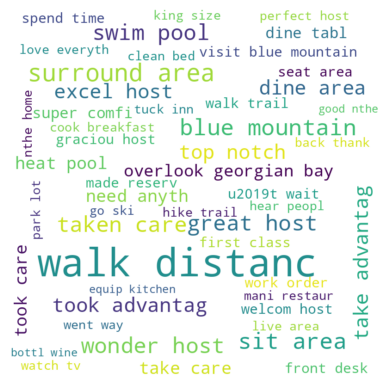

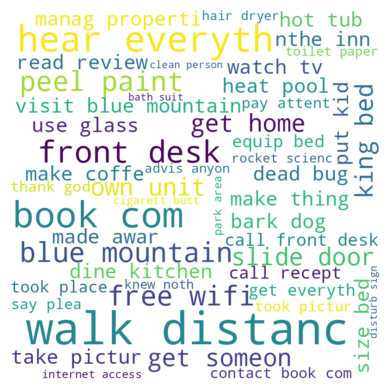

In [83]:
plotWordCloud(top50_pos_verb_phrase, **wordcloud_args)
print("\n")
plotWordCloud(top50_neg_verb_phrase, **wordcloud_args)

Verb phrases seem to be a bit better because there are less words like "blue mountain", or "front desk" that don't have positive or negative connotations. Also, especially the positive verb phrases are a lot more diverse and mostly seem to have clear positive connotations which is helpful.

# Q3

####(a) Use mutual information (MI) with ground truth sentiment to rank the top-50 most sentimentbearing non-stopwords in the review collection. Show the word cloud. Which words get the highest MI values? Does this make sense?

In [84]:
# get Top K mutual information terms from the dataframe
def getMI(topk, df, label_column='groundTruth'):
    miScore = []
    for word in topk:
        miScore.append([word[0]]+[metrics.mutual_info_score(df[label_column], df[word[0]])])
    miScoredf = pd.DataFrame(miScore).sort_values(1,ascending=0)
    miScoredf.columns = ['Word','MI Score']
    return miScoredf

In [209]:
def getTopKWordsOriginal(df, kwords):

    stop = get_stop_words()
    counter = Counter()

    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update([word.lower()
                            for word
                            in re.findall(r'\w+', review)
                            if word.lower() not in stop and len(word) > 2])
    topk = counter.most_common(kwords)
    return topk

In [210]:
top50 = getTopKWordsOriginal(reviewDF, 50)
finaldf = dataFrameTransformation(hotelDf, reviewDF, top50)

In [211]:
miScoredf = getMI(top50, finaldf)

In [212]:
miScoredf.head()

,Word,MI Score
34,hosts,0.034283
2,breakfast,0.025106
42,front,0.019385
28,beautiful,0.015547
44,wonderful,0.015107


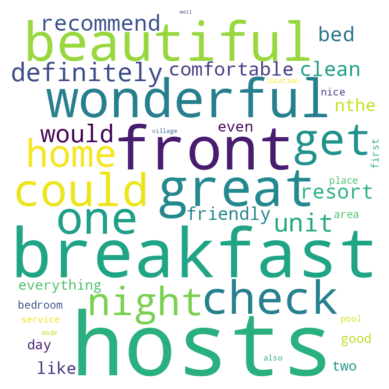

In [213]:
plotWordCloud(miScoredf.set_index('Word')['MI Score'].to_dict(), **wordcloud_args)

"hosts", "breakfast", "front", "beautiful", "wonderful" got the highest MI values which for some makes sense as they are clearly positive words. For words like hosts, breakfast, front, seem like words mentioned often in all reviews. So I'm not so sure how these words would be related strongly to only side of a review.

####(b) Repeat this analysis for the top-50 noun phrases using the grammar you found most effective in Q2. Which noun phrases get the highest MI values? Based on these results what would you recommend the hotels in your city might need to improve?

In [214]:
def getTopKVP_(df, kVPs):

    counter = Counter()
    reviews = df['reviewCol'].values

    for review in reviews:
            counter.update(flatten_phrase_lists([word
                            for word
                            in get_terms(chunker.parse(pos_tag(re.findall(r'\w+', review))))
                            ]))
    topk = counter.most_common(kVPs)
    return topk

In [215]:
top50_VP = getTopKVP_(reviewDF, 50)
finaldf_VP = NPdataFrameTransformation(hotelDf, reviewDF, top50_VP)

In [216]:
miScoredf_VP = getMI(top50_VP, finaldf_VP)

In [217]:
miScoredf_VP.head()

,Word,MI Score
20,hear everyth,0.004203
49,peel paint,0.003360
15,book com,0.002938
27,free wifi,0.002198
45,get someon,0.001485


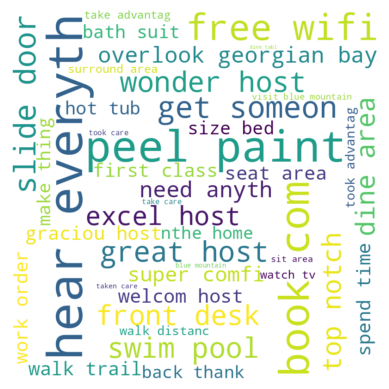

In [218]:
plotWordCloud(miScoredf_VP.set_index('Word')['MI Score'].to_dict(), **wordcloud_args)

"hear everyth", "peel paint" are the phrases that got highest MI values which clearly suggests that hotels should improve with noise complaint issues and should repaint.

# Q4

####(a) For ground truth sentiment, calculate the top-50 words according to Pointwise Mutual Information (PMI) of the word occurring with (i) positive reviews and (ii) negative reviews. Show the word cloud for each category.

In [219]:
# Simple example of getting pointwise mutual information of a term

def demo_pmiCal(df,word):
    pmilist=[]
    N = df.shape[0]
    for sentiment in ['positive','negative']:
        for word_present in [False,True]:
            px = sum(df['groundTruth']==sentiment)
            py = sum(df[word]==word_present)
            pxy = len(df[(df['groundTruth']==sentiment) & (df[word]==word_present)])

            if pxy==0:#Log 0 cannot happen
                pmi = math.log((pxy+0.0001)*N/(px*py))
            else:
                pmi = math.log(pxy*N/(px*py))

            pmilist.append([sentiment]+[word_present]+[px]+[py]+[pxy]+[pmi])

    # assemble the results into a dataframe
    pmidf = pd.DataFrame(pmilist)
    pmidf.columns = ['sentiment (x)','word_present (y)','px','py','pxy','pmi']
    return pmidf

In [220]:
# Compute PMI for all terms and all possible labels
def pmiForAllCal(df, topk_word, gt_sentiment, label_column='groundTruth'):
    #Try calculate all the pmi for top k and store them into one pmidf dataframe

    index = [x[0] for x in topk_word]
    pmiDf = pd.DataFrame(index=index, columns=['pmi'])

    for (word, count) in tqdm(topk_word):
        pmiDf.at[word, 'pmi'] = pmiCalc(df,word,gt_sentiment,label_column)

    return pmiDf


def pmiCalc(df, word, gt_sentiment, label_column='groundTruth'):

    N = df.shape[0]

    px = sum(df[label_column]==gt_sentiment)
    py = sum(df[word]==True)
    pxy = len(df[(df[label_column]==gt_sentiment) & (df[word]==True)])

    if pxy==0:#Log 0 cannot happen
        pmi = math.log((pxy+0.0001)*N/(px*py))
    else:
        pmi = math.log(pxy*N/(px*py))
    return pmi

In [221]:
top50 = getTopKWordsOriginal(reviewDF, 50)
finaldf = dataFrameTransformation(hotelDf, reviewDF, top50)

100%|██████████| 50/50 [00:00<00:00, 593.34it/s]


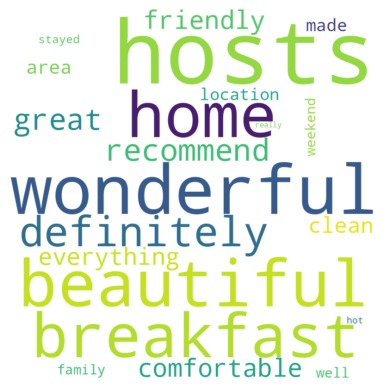

100%|██████████| 50/50 [00:00<00:00, 615.78it/s]


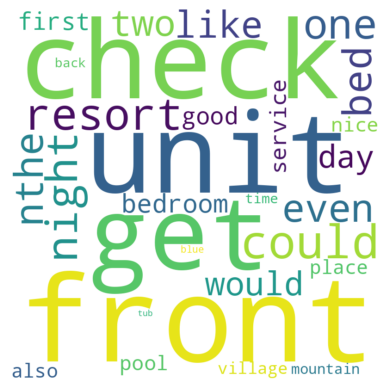

In [222]:
pmiposdf = pmiForAllCal(finaldf,top50,'positive')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

pmiposdf = pmiForAllCal(finaldf,top50,'negative')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)



*   High pmi of "hosts" and "home" in positive reviews suggests that blue mountain has better reviews for intimate air bnb like stay options compared to large hotel chains that relate to terms with high pmi in negative reviews like "front", "check".
*   Words like "resort", "village" are locale-specific to Blue Mountain, which is a ski resort with a village. The higher pmi of the terms in negative reviews can suggest that there are many reviews being not satisfied as the hotel is far from the resort and village.
*   Words like "beautiful" and "wonderful" in positive reviews are usually adjectives that describe scenery or ambiance which could mean that hotels with good reviews had great views or vibes.



####(b) Repeat this analysis for the top-50 noun phrases using your preferred grammar and discuss at least 3 interesting results.

In [223]:
top50_VP = getTopKVP_(reviewDF, 50)
finaldf_VP = NPdataFrameTransformation(hotelDf, reviewDF, top50_VP)

100%|██████████| 50/50 [00:00<00:00, 585.34it/s]


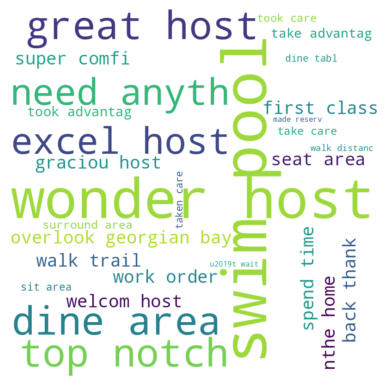

100%|██████████| 50/50 [00:00<00:00, 563.14it/s]


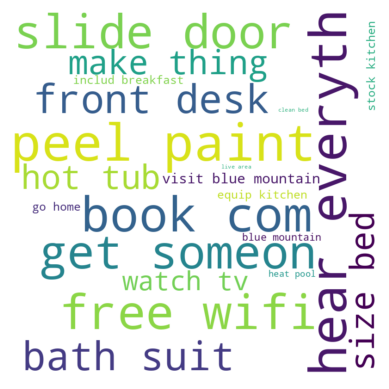

In [224]:
pmiposdf = pmiForAllCal(finaldf_VP,top50_VP,'positive')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

pmiposdf = pmiForAllCal(finaldf_VP,top50_VP,'negative')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)



*   Positive reviews have lots of phrases describing the host with high pmi, hosts must be very important for overall experience.
*   Negative reviews have specific complaints like hearing everything and peeling paint which directly suggests that certain hotels have very clear problems.
* "overlook georgian bay" aligns with our guess in the previous result that there must be some great view or scenery for rooms with great reviews.



####(c) Repeat Q4a) and Q4b) for the single top and single bottom hotel (after ranking by their average ground truth rating). Do you gain any useful hotel-specific insights about what is good and bad about these two hotels? If not, explain why.

In [231]:
top_hotelDf = hotelDf[hotelDf['hotelName']=='Beacon Shore Bed &amp; Breakfast']
bottom_hotelDf = hotelDf[hotelDf['hotelName']=='Ski Blue']

In [235]:
top_reviewDF = reviewDF.iloc[top_hotelDf.index]
bottom_reviewDF = reviewDF.iloc[bottom_hotelDf.index]

100%|██████████| 50/50 [00:00<00:00, 280.89it/s]


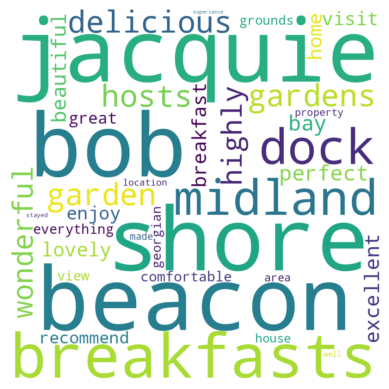

100%|██████████| 50/50 [00:00<00:00, 431.10it/s]


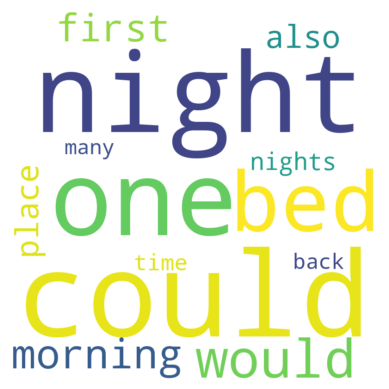

In [253]:
top50 = getTopKWordsOriginal(top_reviewDF, 50)
finaldf = dataFrameTransformation(hotelDf, reviewDF, top50)

pmiposdf = pmiForAllCal(finaldf,top50,'positive')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

pmiposdf = pmiForAllCal(finaldf,top50,'negative')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

100%|██████████| 50/50 [00:00<00:00, 154.53it/s]


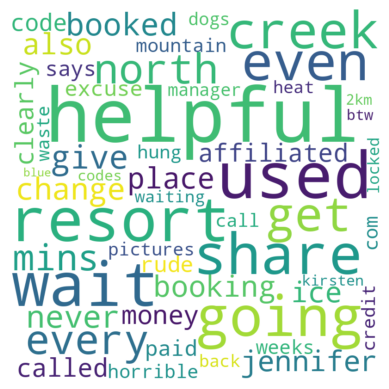

100%|██████████| 50/50 [00:00<00:00, 499.29it/s]


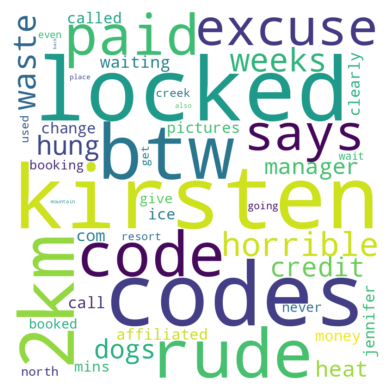

In [254]:
top50 = getTopKWordsOriginal(bottom_reviewDF, 50)
finaldf = dataFrameTransformation(hotelDf, reviewDF, top50)

pmiposdf = pmiForAllCal(finaldf,top50,'positive')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

pmiposdf = pmiForAllCal(finaldf,top50,'negative')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

100%|██████████| 50/50 [00:00<00:00, 626.81it/s]


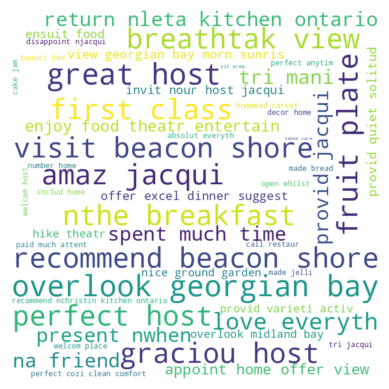

100%|██████████| 50/50 [00:00<00:00, 479.65it/s]


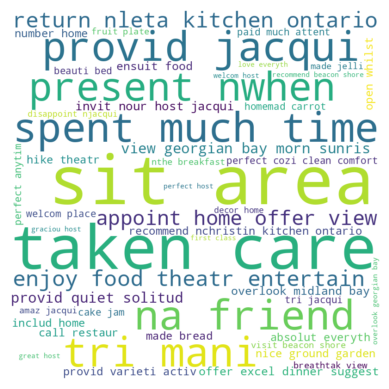

In [255]:
top50_VP = getTopKVP_(top_reviewDF, 50)
finaldf_VP = NPdataFrameTransformation(hotelDf, reviewDF, top50_VP)
pmiposdf = pmiForAllCal(finaldf_VP,top50_VP,'positive')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

pmiposdf = pmiForAllCal(finaldf_VP,top50_VP,'negative')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

100%|██████████| 4/4 [00:00<00:00, 406.12it/s]


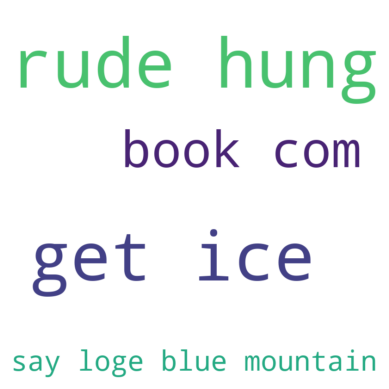

100%|██████████| 4/4 [00:00<00:00, 385.73it/s]


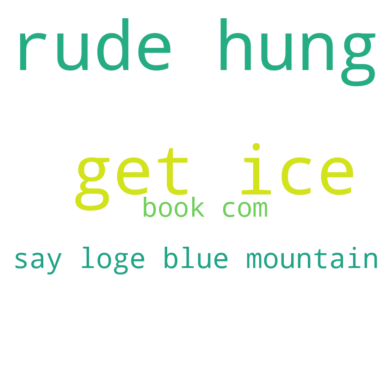

In [256]:
top50_VP = getTopKVP_(bottom_reviewDF, 50)
finaldf_VP = NPdataFrameTransformation(hotelDf, reviewDF, top50_VP)
pmiposdf = pmiForAllCal(finaldf_VP,top50_VP,'positive')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

pmiposdf = pmiForAllCal(finaldf_VP,top50_VP,'negative')
#Sorted top pmi words for positive reviews
pmiposdf.sort_values('pmi',ascending=0)
plotWordCloud(pmiposdf['pmi'].to_dict(), **wordcloud_args)

For the top hotel, for both the top words and phrases, the positive review word cloud is very descriptive and full with clearly positive words while the negative review world cloud doesn't seem like any word has clearly negative connotations.

On the other hand, for the bottom hotel, the positive reviews don't have words with high pmi, and the negative reviews have more words with high pmi.

# Q5


In [257]:
def getHistogram(df, measure, title,figsize=(10,5)):
    fig = plt.figure(figsize=figsize)
    plt.title(title)

    if measure=='both':
        x = [df['ratingScore'].values/5]
        y = [df['vader'].values]
        bins = np.linspace(-1, 1, 100)
        plt.hist(x, bins, label='normalized Ground Truth')
        plt.hist(y, bins, label='vader')
        plt.legend(loc='upper right')
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        plt.hist(df[measure].values)

    plt.xlabel("Value")
    plt.ylabel("Frequency")

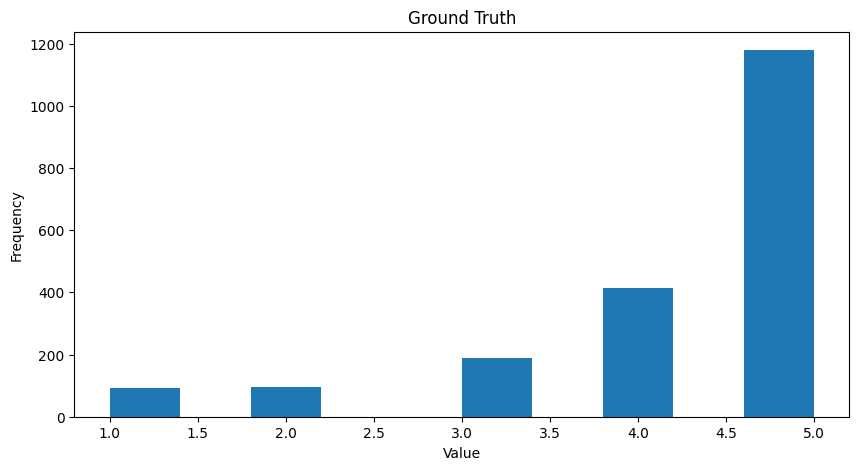

In [258]:
#what is the distrubution in ground truth scores like?
getHistogram(finaldf,'ratingScore', 'Ground Truth')

Higher frequency, higher ground truth score

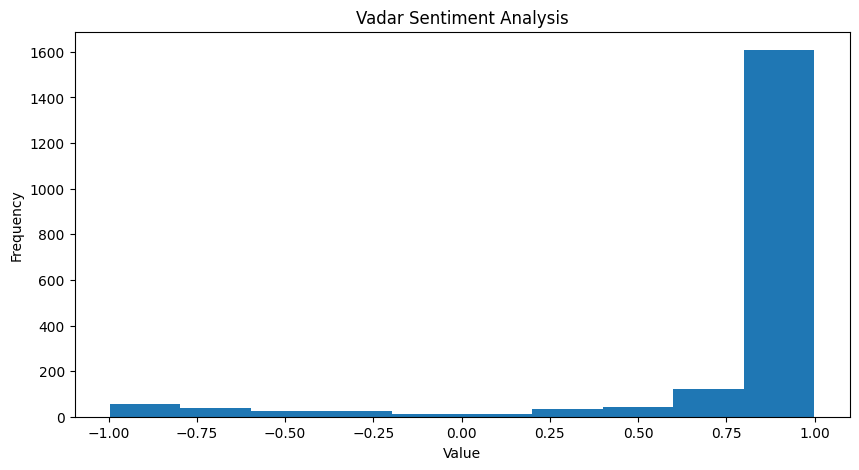

In [260]:
# what is the distrubtuion in vader scores like?
getHistogram(finaldf, 'vader', 'Vadar Sentiment Analysis')

higher frequency, higher vadar sentiment

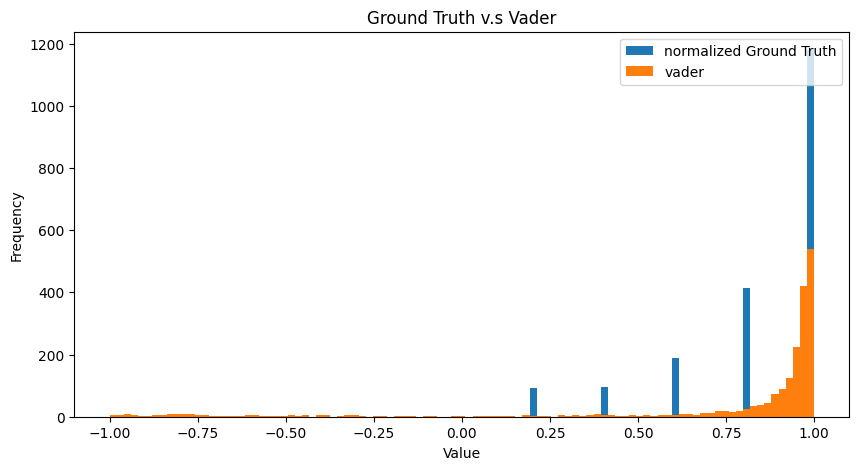

In [261]:
# how do the distrubutions compare between ground truth (normalized) and vader
getHistogram(finaldf, 'both', 'Ground Truth v.s Vader')